In [1]:
import cv2
import numpy as np
import glob
import pylab as plt
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from PIL import Image
#import torchvision
#from torch.utils.data import DataLoader
#im=cv2.imread('sticker.jpg')
#print(im)
#cv2.imshow('image',im)

<h4>Different way of image loader</h4>(below,comented out)

In [2]:
#img_dir = "F:\\books\\ML\\projects\\ProjectPython\\image" # Enter Directory of all images 
#data_path = os.path.join(img_dir,'*jpg')
#files = glob.glob(data_path)
#data = []#
#for f1 in files:                          #doesn't work so far
#    img = cv2.imread(f1)
#    data.append(img)
#print(data)

[]


In [33]:
#def load_dataset():
#data_path = 'image/'                            #data_path = 'data/train/'
#train_dataset = torchvision.datasets.ImageFolder(
#        root=data_path,
#        transform=torchvision.transforms.ToTensor()
#    )
#train_loader = torch.utils.data.DataLoader(
#        train_dataset,
#        batch_size=64,
#        num_workers=0,
#        shuffle=True                                                  #works so far
#    )
#    #print(type(train_dataset))
    #return train_loader


In [8]:
datadir = 'data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256),interpolation=Image.NEAREST),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])                      #works so far

train_data = datasets.ImageFolder(datadir,transform=train_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [9]:
retransform = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = retransform(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

<h6>Images of dataset</h6>

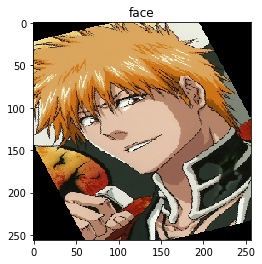

In [12]:
image_batch=iter(trainloader)
img,lab=next(image_batch)
imshow(img[0],'face')

<h4>Model</h4>

In [13]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\DOLPHIN/.cache\torch\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████| 32342954/32342954 [00:22<00:00, 1441447.98it/s]


In [14]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

)


In [15]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [16]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 3),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [19]:
epochs = 2
steps = 0
running_loss = 0
print_every=3
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:         
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}..")
            running_loss = 0

Epoch 1/2.. Train loss: 0.463..
Epoch 2/2.. Train loss: 0.252..


<h3>Test</h3>

In [20]:
test_transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor()])
                               
def image_loader(image_path):
    image=Image.open(image_path)
    image=test_transform(image).unsqueeze(0)
    return image.to(device, torch.float)

In [29]:
image_1 = image_loader('test/l4.jpg')
image_2 = image_loader('test/n1.jpeg')
image_3 = image_loader('test/i1.jpeg')

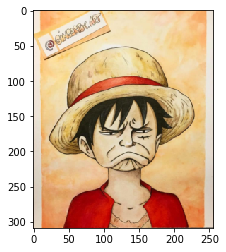

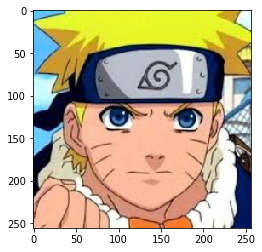

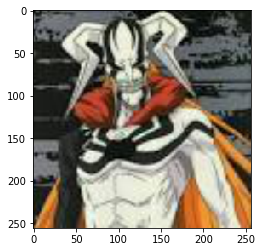

In [30]:
plt.ion()
plt.figure()
imshow(image_1 )
plt.figure()
imshow(image_2)
plt.figure()
imshow(image_3)

In [31]:
model.eval()
with torch.no_grad():
    image_1= image_1.to(device)
    image_2= image_2.to(device)
    image_3= image_3.to(device)
    logps1 = model.forward(image_1)
    logps2 = model.forward(image_2)
    logps3 = model.forward(image_3)
    ps1 = torch.exp(logps1)
    ps2 = torch.exp(logps2)
    ps3 = torch.exp(logps3)
    top_p1, top_class1 = ps1.topk(1, dim=1)
    top_p2, top_class2 = ps2.topk(1, dim=1)
    top_p3, top_class3 = ps3.topk(1, dim=1)
#model.train()

In [32]:
print(train_data.class_to_idx)
print('Probability - Classes identified:')
print(top_p1,top_class1)
print(top_p2,top_class2)
print(top_p3,top_class3)

{'ichigo': 0, 'luffy': 1, 'naruto': 2}
Probability - Classes identified:
tensor([[0.5706]]) tensor([[1]])
tensor([[0.9668]]) tensor([[2]])
tensor([[0.7616]]) tensor([[0]])


<h2>Result!!</h2>
done nigga done